# The Variational Autoencoder!
In this notebook, we create an implementation of the variational auto encoder. First, we will import the relevant libraries.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm
import torchvision
from torchvision.transforms import transforms

Use the correct device. If we're using a gpu, it should be cuda. However, if not, the device should be the cpu

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# The Architecture
The Variational Autoencoder is defined to be a model that is able to generate images. We do this by first converting a training image $x$ into latent variables. This is done in the encoder neural network $f_{\theta}(x)$. $f_{\theta}$ will encode our image $x$ into normal distribution parameters $\mu$ and $\sigma^2$, to have latent variables sampled from $z \sim N(\mu, \sigma^2)$. We then send our sample into a decoder that will be able to reconstruct our sample into a generated image! The model is illustrated as follows

<img src="architecture.png">

## Theoretical Underpinnings
More mathematically, we represent the encoder as $g_{\phi}(x)$, and our decoder as $f_{\theta}(x)$. Where $\phi$ and $\theta$ denote that these functions are parameterized. Theoretically, we would like to maximize the probability of our dataset when we create a set of new images, i.e we would like to maximize $$\arg\max_{\phi, \theta}p(x)$$ This however, may be difficult to do, so we utilize the Evidence Lower Bound Observation, otherwise known as ELBO. We first observe that $$\arg\max_{\phi, \theta} p(x) = \arg\max_{\phi, \theta} \log p(x)$$ Further, notice that:
$$p(x) = \int_{X}p_{\theta}(x|z) p(z) dz = \int_{X}p_{\theta}(x|z)p(z) \frac{q_{\phi}(z|x)}{q_{\phi}(z|x)}dz = E[p_{\theta}(x|z) \frac{p(z)}{q_{\phi}(z|x)}]$$
Further realize that the log is a concave function, and that the expected value is a convex combination of values over a probability space $p_i \in [0, 1]$. Thus, we have that:
$$\log p(x) \geq E[\log p_{\theta}(x|z)] - D_{KL}(q_{\phi}(z|x) || p(z))$$
Intuitively speaking, the first expected value measures the reconstruction loss, while the second KL divergence term keeps our output parameters from the encoder close to where we actually want to sample from. While this may look like a daunting loss function, if we were to model our prior and posterior as a normal distribution, our loss function becomes much easier to parse. If we were to model $q_{\phi}(z|x) \sim N(g(x), diag(h(x)))$, $p(z) \sim N(0, I)$, and $p_{\theta}(x|z) \sim N(f(z), \frac{\lambda}{2}I)$, our loss function becomes:
$$||x - f(z)||_2^2 - \lambda (\log(\frac{\sigma_p}{\sigma_q}) + \frac{\sigma_q^2 + (\mu_p - \mu_q)^2}{2\sigma_p^2} - \frac{1}{2})$$

## The Reparamaterization Trick
You may have noticed that if we were to sample $z \sim N(\mu, \sigma^2)$, and send it through the decoder, there aren't any real gradients that will be able to backpropagate to the encoder by reconstruction. To fix this, we employ the reparameterization trick. In other words, we say:
$$z = \mu + \sigma \odot N(0, I)$$

## The Linear Architecture
Our first try at a VAE will be to use a simple Feed Forward Network Architecture. We will define the FFN as:
$$\texttt{...<-> Linear <-> ReLU <-> Linear <-> ReLU <-> Linear <-> ReLU <-> Linear <-> SAMPLE}$$

In [28]:
class Encoder(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers_mean = [nn.Flatten(), nn.Linear(28 * 28, layers[0])]
        self.layers_logstd = [nn.Flatten(), nn.Linear(28 * 28, layers[0])] #we output logstd for stability

        for i in range(1, len(layers)):
            self.layers_mean.append(nn.ReLU())
            self.layers_mean.append(nn.Linear(layers[i - 1], layers[i]))

            self.layers_logstd.append(nn.ReLU())
            self.layers_logstd.append(nn.Linear(layers[i - 1], layers[i]))

        self.layers_mean = nn.Sequential(*self.layers_mean)
        self.layers_logstd = nn.Sequential(*self.layers_logstd)

    def forward(self, x):
        mu = self.layers_mean(x)
        s = self.layers_logstd(x)
        return mu, s

class Decoder(nn.Module):
    def __init__(self, layers):
        #We take in a dimension layers[-1] gaussian noise vector
        super().__init__()
        layers.reverse()
        self.decoder = []
        for i in range(0, len(layers) - 1):
            self.decoder.append(nn.Linear(layers[i], layers[i + 1]))
            self.decoder.append(nn.ReLU())
        self.decoder.append(nn.Linear(layers[-1], 28 * 28))
        self.decoder = nn.Sequential(*self.decoder)
    def forward(self, z):
        z = self.decoder(z)
        z = z.view(z.shape[0], 1, 28, 28)
        return z

In [29]:
class VAE(nn.Module):
    def __init__(self, layers, reg):
        super().__init__()
        self.pos_mean = torch.zeros(layers[-1]).to(device)
        self.pos_std = (torch.zeros(layers[-1]) + 1).to(device)
        self.encoder = Encoder(layers)
        self.decoder = Decoder(layers)
        self.reg = reg


    def reparam(self, mu, sigma):
        return mu + sigma * torch.normal(0, 1, sigma.shape).to(device)

    def forward(self, x):
        mu, s = self.encoder(x)
        sigma = torch.nn.functional.softplus(s) + 1e-8
        z = self.reparam(mu, sigma)
        out = self.decoder(z)
        kl = self.reg * self.kl_loss(mu, sigma, self.pos_mean, self.pos_std)
        recon = nn.functional.mse_loss(out, x, reduction = 'sum') / x.shape[0]
        return recon + kl

    def kl_loss(self, qm, qv, pm, pv):
        #return the kl loss between two normals
        element_wise = 0.5 * (torch.log(pv) - torch.log(qv) + qv / pv + (qm - pm).pow(2) / pv - 1)
        kl = element_wise.sum(-1)
        return kl.mean()

In [30]:
transform_train = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
transform_test = transforms.Compose(
    [     transforms.ToTensor(),
          transforms.Normalize((0.1307,), (0.3081,))
          ])

train = torchvision.datasets.MNIST("MNIST", True, transform_train, download = True)
valid = torchvision.datasets.MNIST("MNIST", False, transform_test, download = True)

In [31]:
train

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [32]:

#CREATE A TRAINING LOOP
def training_loop(model, train, valid, epochs = 10, batch_size = 64, lr = 1e-3, momentum = 0.9, lr_decay = 0.99, l2_reg = 0):

    #SET UP LOSS FUNCTION AND OPTIMIZER, AS WELL AS BATCH ENUMERATORS
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True) #batch both valid and training
    valid_loader = torch.utils.data.DataLoader(valid, batch_size = batch_size, shuffle = True)

    optimizer = torch.optim.AdamW(params = model.parameters(), lr = lr, betas = (momentum, lr_decay), weight_decay = l2_reg) #Use Adam Optimization

    train_loss_history = []
    valid_loss_history = []
    max_acc = 0
    for epoch in range(epochs):
        #TRAIN THE MODEL
        with tqdm(train_loader, unit="batch") as tepoch:
            model.train()
            epoch_loss = []
            train_acc = 0
            train_loss = 0
            for data, target in tepoch:
                tepoch.set_description(f"Epoch {epoch + 1}")

                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                loss = model(data) #forward pass
                train_loss += loss.item()/len(train) * batch_size
                loss.backward()
                optimizer.step()
                tepoch.set_postfix(loss=loss.item())

            #EVALUATE MODEL ON ACCURACY AND CROSS ENTROPY METRICS
            model.eval()
            valid_loss = 0
            with torch.no_grad():
                valid_acc, valid_loss = 0, 0
                for batch_idx, (data, target) in enumerate(valid_loader):
                    data, target = data.to(device), target.to(device)
                    loss = model(data)
                    valid_loss += loss.item() / len(valid) * batch_size
                print(f'Average Training Loss is {train_loss}; Validation loss is {valid_loss} for epoch {epoch + 1}')
                train_loss_history.append(train_loss)
                valid_loss_history.append(valid_loss)

    #PLOT VALIDATION AND TRAINING LOSS PROGRESS

    plt.plot(range(epochs), train_loss_history)
    plt.plot(range(epochs), valid_loss_history)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["train", "valid"], loc=0, frameon=True)
    plt.show()

Epoch 1: 100%|██████████| 938/938 [00:32<00:00, 29.14batch/s, loss=338]


Average Training Loss is 427.1152258463545; Validation loss is 326.73279042968727 for epoch 1


Epoch 2: 100%|██████████| 938/938 [00:31<00:00, 29.43batch/s, loss=268]


Average Training Loss is 305.3930799641927; Validation loss is 286.1693866210938 for epoch 2


Epoch 3: 100%|██████████| 938/938 [00:31<00:00, 29.42batch/s, loss=236]


Average Training Loss is 272.0579439615884; Validation loss is 262.7181202148436 for epoch 3


Epoch 4: 100%|██████████| 938/938 [00:33<00:00, 27.96batch/s, loss=240]


Average Training Loss is 253.9224405598958; Validation loss is 245.51363994140618 for epoch 4


Epoch 5: 100%|██████████| 938/938 [00:33<00:00, 28.05batch/s, loss=248]


Average Training Loss is 239.70277664388004; Validation loss is 233.87232148437496 for epoch 5


Epoch 6: 100%|██████████| 938/938 [00:32<00:00, 28.61batch/s, loss=211]


Average Training Loss is 229.97927576497383; Validation loss is 228.3656692382811 for epoch 6


Epoch 7: 100%|██████████| 938/938 [00:38<00:00, 24.41batch/s, loss=225]


Average Training Loss is 223.64724000651046; Validation loss is 222.05475410156248 for epoch 7


Epoch 8: 100%|██████████| 938/938 [01:02<00:00, 14.99batch/s, loss=198]


Average Training Loss is 219.7061854654951; Validation loss is 221.4582362304688 for epoch 8


Epoch 9: 100%|██████████| 938/938 [01:06<00:00, 14.17batch/s, loss=201]


Average Training Loss is 216.46656712239567; Validation loss is 217.1609432617187 for epoch 9


Epoch 10: 100%|██████████| 938/938 [00:51<00:00, 18.08batch/s, loss=241]


Average Training Loss is 214.07841844075517; Validation loss is 215.20150908203115 for epoch 10


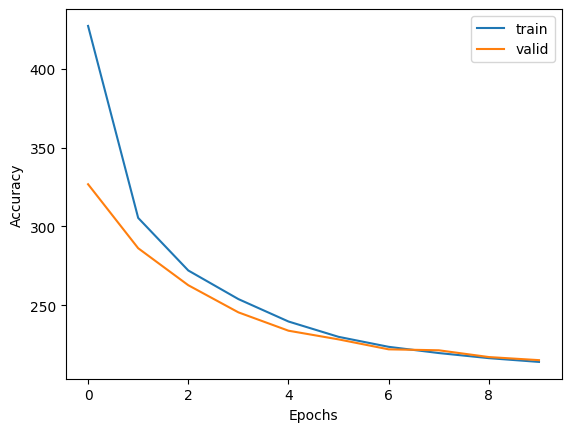

In [45]:
model = VAE(layers = [600, 500, 400, 250], reg = 3.5).to(device)
training_loop(model, train, valid, lr = 9e-4, batch_size = 64, epochs = 10)

C:\Users\micha\AppData\Local\Temp\ipykernel_32180\3837809037.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


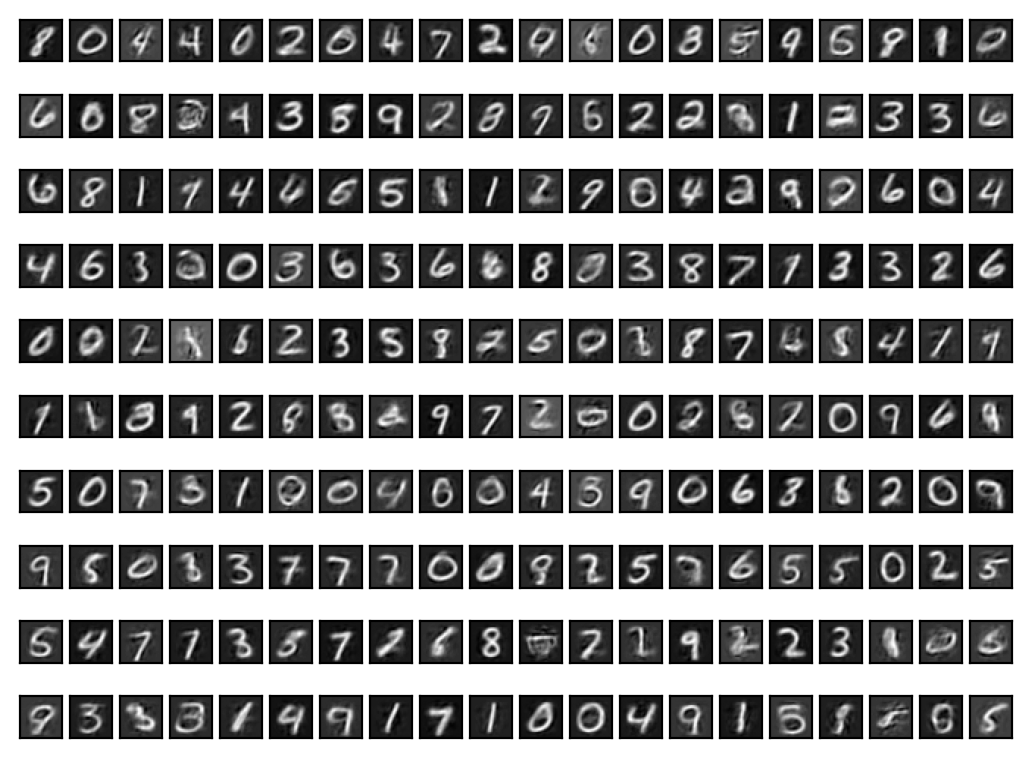

In [47]:
f, axarr = plt.subplots(10,20)
samples = torch.normal(0, 1, size = (20 * 10, 1, 250)).to(device)
sampled_numbers = model.decoder(samples)
for i in range(10):
    for j in range(20):
        axarr[i, j].imshow(sampled_numbers.cpu().detach().numpy()[j * 10 + i][0], cmap='gray')
        axarr[i, j].set_xticks([])
        axarr[i, j].set_yticks([])
f.set_dpi(200)
f.show()

C:\Users\micha\AppData\Local\Temp\ipykernel_32180\1757497045.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


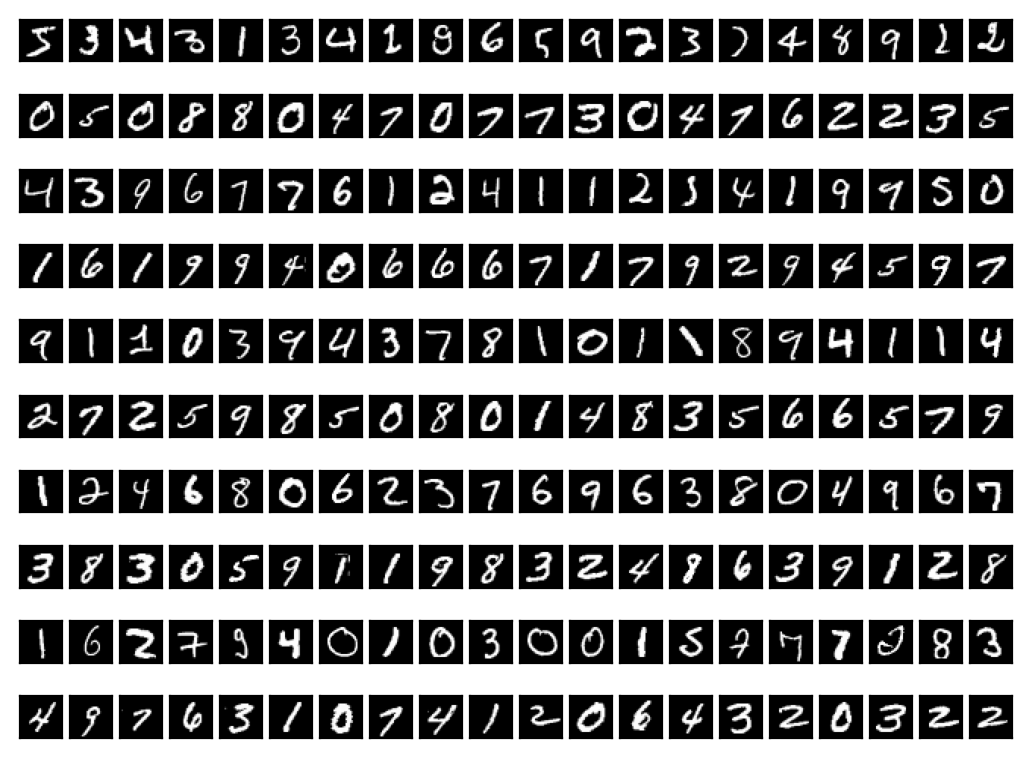

In [44]:
f, axarr = plt.subplots(10,20)
for i in range(10):
    for j in range(20):
        sample = train[j * 10 + i][0]
        axarr[i, j].imshow(sample[0], cmap = 'gray')
        axarr[i, j].set_xticks([])
        axarr[i, j].set_yticks([])
f.set_dpi(200)
f.show()